# Spatio-Temporal Gaussian Process Modeling in Reservoir Engineering

In reservoir engineering, a fundamental challenge is to understand and predict the dynamics of reservoir properties over space and time. This involves modeling key variables such as Gas Phase Pressure (BGPR), Gas In-Place (BGIP), Oil In-Place (BOIP), and Water In-Place (BWIP) across a reservoir grid. The task is to develop a predictive model capable of capturing the spatial-temporal evolution of these variables in the context of a three-phase flow system.

#### Mathematical Formulation
Consider a reservoir represented by a spatial grid of dimensions $10 \times 10 \times 3$ (denoting $x, y, z$ coordinates respectively) and temporal measurements spanning $T$ time steps. Let the set of sensor locations be represented by $\mathcal{S} = \{s_1, s_2, \ldots, s_{30}\}$ where each $s_i$ is a tuple $(x, y, z)$ indicating the cell coordinates. The sensor at each location $s_i$ collects time-series data for the reservoir variables, which are denoted as follows:

- $P_{g}(s, t)$: Gas Phase Pressure (BGPR) at location $s$ and time $t$.
- $V_{g}(s, t)$: Gas In-Place (BGIP) at location $s$ and time $t$.
- $V_{o}(s, t)$: Oil In-Place (BOIP) at location $s$ and time $t$.
- $V_{w}(s, t)$: Water In-Place (BWIP) at location $s$ and time $t$.

#### Objective
The objective is to construct a Latent Model Construction (LMC) using Gaussian Processes (GPs) to model the spatio-temporal relationships among these variables. The LMC aims to learn a function $f: \mathbb{R}^4 \rightarrow \mathbb{R}^4$ such that:

$$ f(s, t) = [P_{g}(s, t), V_{g}(s, t), V_{o}(s, t), V_{w}(s, t)] $$

where $s \in \mathbb{R}^3$ represents the spatial coordinates and $t \in \mathbb{R}$ represents the time.


## Governing Equation for Discretized Multi-Phase Flow in a Porous Medium

In the following, let subscript $ i $ denote a discrete quantity defined in cell $ i $ and subscript $ ij $ denote a discrete quantity defined at the connection between two cells $ i $ and $ j $. Two cells share a connection if they are adjacent geometrically in the computational grid or share an explicit Non-Neighbor Connection (``NNC''). For example $ \upsilon_{o, ij} $ is the oil flux from cell $ i $ to cell $ j $. For oriented quantities such as fluxes, the orientation is taken to be from cell $ i $ to cell $ j $, and the quantity is skew-symmetric $ (\upsilon_{o, ij} = -\upsilon_{o, ij}) $, whereas non-oriented quantities such as the transmissibility $ T_{ij} $ are symmetric $ (T_{ij} = T_{ji}) $. Quantities with superscript $ 0 $ are taken at the start of the discrete time step, other quantities are at the end of the time step. Superscripts or subscripts applied to an expression in parenthesis apply to each element in the expression.

*For Water Phase:*

$$
R_{w,i} = \phi_{\text{{ref}},i} V_i \frac{\partial}{\partial t} \left( m_{\phi} b_w s_w \right)_i + \sum_{j \in C(i)} (b_w \lambda_w m_T)_{U_{(w,ij)}}T_{ij} (p_{w,i} - p_{w,j} - g \big(\frac{\rho_{w,i}+\rho_{w,j}}{2} \big) (z_i - z_j)) + T_{w,i}M_{w,i}[p_i-(p_{bhp,w}+h_{w,i})] = 0
$$
*For Oil Phase:*

$$
R_{o,i} = \phi_{\text{{ref}},i} V_i \frac{\partial}{\partial t} \left( m_{\phi} (b_o s_o + r_{og} b_g s_g) \right)_i 
+ \sum_{j \in C(i)} \Big[ (b_o \lambda_o m_T)_{U_{(o,ij)}}T_{ij} (p_{o,i} - p_{o,j} - g \big(\frac{\rho_{o,i}+\rho_{o,j}}{2} \big) (z_i - z_j)) 
 + (r_{og} b_g \lambda_g m_T)_{U_{(g,ij)}}T_{ij} (p_{g,i} - p_{g,j} - g \big(\frac{\rho_{g,i}+\rho_{g,j}}{2} \big) (z_i - z_j)) \Big] 
+ T_{w,i}M_{o,i}[p_i-(p_{bhp,w}+h_{w,i})] = 0
$$
*For Gas Phase:*

$$
R_{g,i} = \phi_{\text{{ref}},i} V_i \frac{\partial}{\partial t} \left( m_{\phi} (b_g s_g + r_{go} b_o s_o) \right)_i 
+ \sum_{j \in C(i)} \Big[ (b_g \lambda_g m_T)_{U_{(g,ij)}}T_{ij} (p_{g,i} - p_{g,j} - g \big(\frac{\rho_{g,i}+\rho_{g,j}}{2} \big) (z_i - z_j)) 
\quad + (r_{go} b_o \lambda_o m_T)_{U_{(o,ij)}}T_{ij} (p_{o,i} - p_{o,j} - g \big(\frac{\rho_{o,i}+\rho_{o,j}}{2} \big) (z_i - z_j)) \Big] 
+ T_{w,i}M_{g,i}[p_i-(p_{bhp,w}+h_{w,i})] = 0
$$

Where the upwind direction is defined as:

$$
U(\alpha, ij) = 
\begin{cases}
i, & \text{if } \Delta \Phi_{\alpha,ij} \geq 0 \\
j, & \text{if } \Delta \Phi_{\alpha,ij} < 0  
\end{cases}
$$



### Initial Conditions

The system initiates with a constant pressure $ p_{\alpha,i} = \text{const} $ across all cells $i$.

In [13]:
import os
output = 'opm_data.mat'  # Change the extension to .zip (or whatever the actual extension is)

# Only download if the file doesn't exist
if not os.path.exists(output):
    import gdown
    url = 'https://drive.google.com/uc?export=download&id=1ClOGtiwuy5UCdyPhaYTg2NZylUWaCQxP'
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists, skipping download.")

opm_data.mat already exists, skipping download.


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import math
import gpytorch
import tqdm

## Dataset

In [15]:
# Load the data
data = sio.loadmat('opm_data.mat')

definitions = {
    'BGIP': 'Gas In-Place', 
    'BGIPG': 'Gas In-Place (Gas Phase)', 
    'BGIPL': 'Gas In-Place (Liquid Phase)', 
    'BGPC': 'Capillary Pressure (Gas-Oil)', 
    'BGPR': 'Gas Phase Pressure', 
    'BGPV': 'Pore Volume (Gas)', 
    'BGSAT':'Gas Saturation', 
    'BGVIS': 'Gas Viscosity',
    'BRS': 'Gas-Oil Ratio',
    'BOIP': 'Oil In-Place', 
    'BOIPG': 'Oil In-Place (Gas Phase)', 
    'BOIPL': 'Oil In-Place (Liquid Phase)', 
    'BOPV': 'Pore Volume (Oil)', 
    'BOSAT': 'Oil Saturation', 
    'BOVIS': 'Oil Viscosity',
    'BPR': 'Oil Phase Pressure', 
    'BRV': 'Oil-Gas Ratio',
    'BWIP': 'Water In-Place', 
    'BWPC': 'Capillary Pressure (Water-Oil)', 
    'BWPR': 'Water Phase Pressure', 
    'BWPV': 'Pore Volume (Water)', 
    'BWSAT': 'Water Saturation', 
    'BWVIS': 'Water Viscosity',
    'BRPV': 'Pore Volume (Reservoir Conditions)'
}

In [16]:
# def get_split_data(data):

#     # Assuming your dictionary is named data_dict
#     arrays = [data[key] for key in ['BGPR', 'BGIP', 'BOIP', 'BWIP']]

#     # Stack the arrays
#     stacked_data = np.stack(arrays, axis=0)

#     # Flatten the data to create (x, y, z, t) as input and values for all categories as output
#     flattened_data = []
#     for x in range(stacked_data.shape[1]):
#         for y in range(stacked_data.shape[2]):
#             for z in range(stacked_data.shape[3]):
#                 for t in range(stacked_data.shape[4]):
#                     values = stacked_data[:, x, y, z, t]
#                     data_point = ([x, y, z, t], values)
#                     flattened_data.append(data_point)

#     # Convert to NumPy array
#     flattened_data = np.array(flattened_data, dtype=object)

#     # Select 30 random locations for training
#     xyz_combinations = list(set([tuple(dp[0][:3]) for dp in flattened_data]))
#     selected_locations = random.sample(xyz_combinations, 30)

#     # Create training and testing datasets
#     train_x, train_y = zip(*[dp for dp in flattened_data if tuple(dp[0][:3]) in selected_locations])
#     test_x, test_y = zip(*[dp for dp in flattened_data if tuple(dp[0][:3]) not in selected_locations])

#     # Convert to NumPy arrays
#     train_x = np.array(train_x)
#     train_y = np.array(train_y)
#     test_x = np.array(test_x)
#     test_y = np.array(test_y)


#     # Plotting the locations of the training data on each z-level
#     z_levels = np.unique(train_x[:, 2])
#     for z in z_levels:
#         plt.figure()
#         plt.title(f"Training Data Locations at z-level {z}")
#         plt.xlabel("x")
#         plt.ylabel("y")
#         z_level_locations = train_x[train_x[:, 2] == z][:, :2]
#         plt.scatter(z_level_locations[:, 0], z_level_locations[:, 1], marker='*', label=f'z = {z}')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

#     # Verify the shapes of the datasets
#     print("Train X shape:", train_x.shape)
#     print("Train Y shape:", train_y.shape)
#     print("Test X shape:", test_x.shape)
#     print("Test Y shape:", test_y.shape)

#     return train_x, train_y, test_x, test_y
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def get_split_data(data):
    # Assuming your dictionary is named data_dict
    arrays = [data[key] for key in ['BGPR', 'BGIP', 'BOIP', 'BWIP']]

    # Stack the arrays
    stacked_data = np.stack(arrays, axis=0)

    # Flatten the data to create (x, y, z, t) as input and values for all categories as output
    flattened_data = []
    for x in range(stacked_data.shape[1]):
        for y in range(stacked_data.shape[2]):
            for z in range(stacked_data.shape[3]):
                for t in range(stacked_data.shape[4]):
                    values = stacked_data[:, x, y, z, t]
                    data_point = ([x, y, z, t], values)
                    flattened_data.append(data_point)

    # Convert to NumPy array
    flattened_data = np.array(flattened_data, dtype=object)

    # Select 30 random locations for training
    xyz_combinations = list(set([tuple(dp[0][:3]) for dp in flattened_data]))
    selected_locations = random.sample(xyz_combinations, 100)

    # Create training and testing datasets
    train_x, train_y = zip(*[dp for dp in flattened_data if tuple(dp[0][:3]) in selected_locations])
    test_x, test_y = zip(*[dp for dp in flattened_data if tuple(dp[0][:3]) not in selected_locations])

    # Convert to NumPy arrays
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)

    # # Scale the data
    # scaler = StandardScaler()
    # train_x_scaled = scaler.fit_transform(train_x)
    # test_x_scaled = scaler.transform(test_x)

    # Plotting the locations of the training data on each z-level
    z_levels = np.unique(train_x[:, 2])
    for z in z_levels:
        plt.figure()
        plt.title(f"Training Data Locations at z-level {z}")
        plt.xlabel("x")
        plt.ylabel("y")
        z_level_locations = train_x[train_x[:, 2] == z][:, :2]
        plt.scatter(z_level_locations[:, 0], z_level_locations[:, 1], marker='*', label=f'z = {z}')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Verify the shapes of the datasets
    print("Train X shape:", train_x.shape)
    print("Train Y shape:", train_y.shape)
    print("Test X shape:", test_x.shape)
    print("Test Y shape:", test_y.shape)


    # add noise to train y
    noise = np.random.normal(0, train_y.std()/10, train_y.shape)

    return train_x, train_y, test_x, test_y

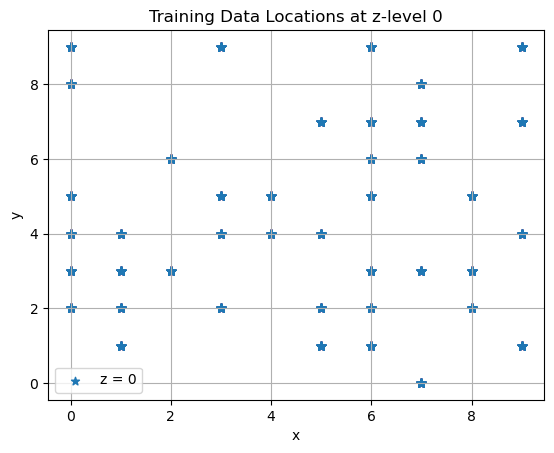

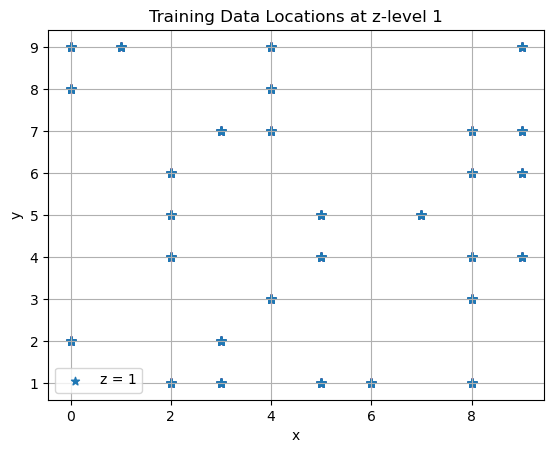

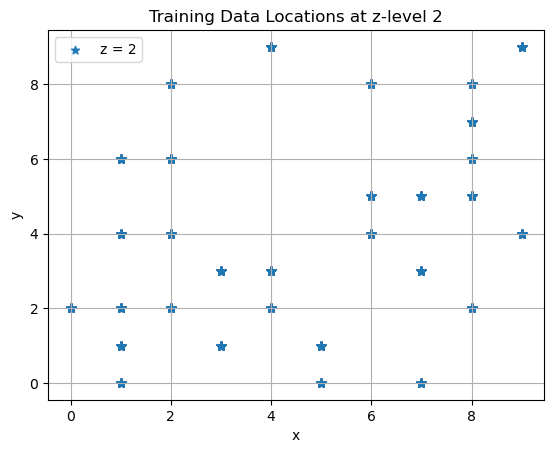

Train X shape: (12400, 4)
Train Y shape: (12400, 4)
Test X shape: (24800, 4)
Test Y shape: (24800, 4)


In [17]:
train_x, train_y, test_x, test_y = get_split_data(data)

# Define the standard deviation of the noise
noise_std = 0.1

# Generate noise and add it to train_y
train_y_noise = train_y + np.random.normal(0, noise_std, train_y.shape)

## Model Description

### Input and Output
Our model aims to predict a set of reservoir variables based on spatio-temporal data. The input to the model, $\mathbf{x}$, is a four-dimensional vector representing spatial coordinates (x, y, z) and time (t), i.e., $\mathbf{x} = [x, y, z, t]$. The output, $\mathbf{y}$, consists of measurements for the following reservoir variables: Gas Phase Pressure (BGPR), Gas In-Place (BGIP), Oil In-Place (BOIP), and Water In-Place (BWIP).

### Multitask Gaussian Process Model
We employ a Multitask Gaussian Process (GP) model, specifically designed to handle multiple outputs. The model captures the correlations not only within each output variable over space and time but also across different variables.

### Latent Model Construction
The core of our model is the Latent Model Construction (LMC) approach, which uses a set of latent, independent Gaussian processes and linearly combines them to model the correlations between the tasks. Each latent function has its own set of inducing points, with a total of $num\_latents = 3$ latent functions used.

### Kernel Functions
For each latent GP, we utilize a Radial Basis Function (RBF) kernel, also known as the Gaussian kernel, which is defined as:

$$
k(\mathbf{x}, \mathbf{x'}) = \sigma^2 \exp\left(-\frac{||\mathbf{x} - \mathbf{x'}||^2}{2l^2}\right)
$$

where $\sigma$ is the amplitude and $l$ is the length-scale parameter. The RBF kernel is a popular choice due to its ability to model smooth variations in the data.

\subsubsection{Mean and Covariance Modules}
Each latent GP has its own mean and covariance modules. The mean function is assumed to be constant, and the covariance function is defined by the RBF kernel. These are parameterized separately for each latent GP.

### Loss Function
The training of the model involves optimizing the variational lower bound of the log likelihood, which in the context of Gaussian processes is referred to as the Evidence Lower Bound (ELBO). The ELBO is given by:

$$
\text{ELBO} = \mathbb{E}_{q(\mathbf{f}|\mathbf{x})}\left[\log p(\mathbf{y}|\mathbf{f})\right] - \text{KL}\left[q(\mathbf{f}|\mathbf{x}) || p(\mathbf{f})\right]
$$

where $q(\mathbf{f}|\mathbf{x})$ is the variational distribution of the latent functions, $p(\mathbf{y}|\mathbf{f})$ is the likelihood of the observed data given the latent functions, and $\text{KL}[\cdot||\cdot]$ denotes the Kullback-Leibler divergence between the variational distribution and the prior.

### Implementation
The model is implemented using GPyTorch, a Gaussian Process library that offers flexibility and efficiency for large-scale GP modeling. This implementation allows for scalable and robust modeling of the spatio-temporal dynamics in reservoir simulation.


/var/folders/c9/xpcdzsn55474rmzrqh4kx1cw0000gn/T/ipykernel_42812/1315665582.py:82: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

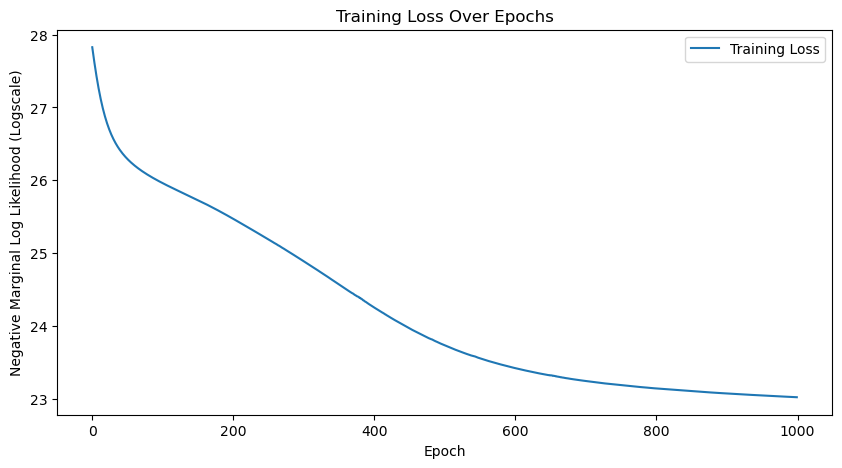

In [18]:
# Assuming train_x and train_y are lists of lists or similar structures
# Convert them to NumPy arrays with a specified dtype
train_x_np = np.array(train_x, dtype=np.float32)
train_y_np = np.array(train_y, dtype=np.float32)

# Now, convert them to PyTorch tensors
train_x_tensor = torch.from_numpy(train_x_np)
train_y_tensor = torch.from_numpy(train_y_np)

# Test data
test_x_np = np.array(test_x, dtype=np.float32)
test_y_np = np.array(test_y, dtype=np.float32)
test_x_tensor = torch.from_numpy(test_x_np)
test_y_tensor = torch.from_numpy(test_y_np)

# Define the MultitaskGPModel class
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 64, 4)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=4,
            num_latents=3,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # Forward function now handles 2D input
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the model and likelihood
num_latents = 3
num_tasks = 4  # Adjust if your tasks number is different
model = MultitaskGPModel()
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

# Training settings
smoke_test = False  # Set to True for a quick test run
num_epochs = 1 if smoke_test else 1000

# Training loop
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_tensor.size(0))

# Store the losses here
losses = []

# Use tqdm for progress bar
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    output = model(train_x_tensor)
    loss = -mll(output, train_y_tensor)
    losses.append(loss.item())  # Store the loss
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses), label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Negative Marginal Log Likelihood (Logscale)')
plt.legend()
plt.show()

In [19]:
# Ensure the model and likelihood are in evaluation mode
model.eval()
likelihood.eval()

# Make predictions on the test data
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_predictions = likelihood(model(test_x_tensor))
    test_y_pred = test_predictions.mean
    test_y_lower, test_y_upper = test_predictions.confidence_region()

# Convert to numpy arrays for easier handling, if needed
test_y_pred_np = test_y_pred.detach().numpy()
test_y_lower_np = test_y_lower.detach().numpy()
test_y_upper_np = test_y_upper.detach().numpy()

# Now test_y_pred, test_y_lower, and test_y_upper contain the predicted mean,
# lower bound, and upper bound for the test data.


Selected cell location: [7. 6. 1.]


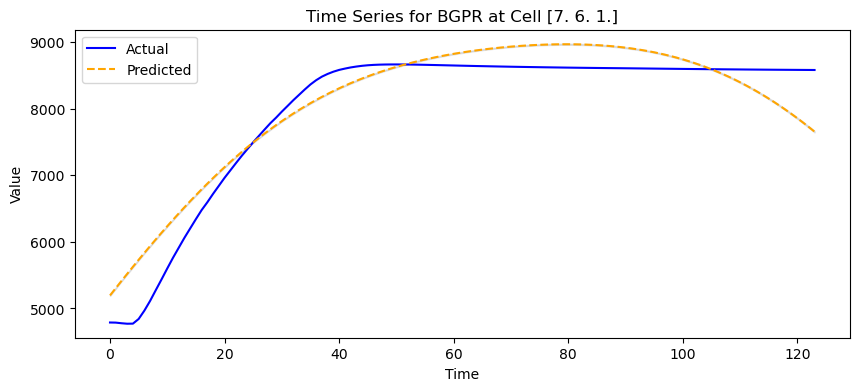

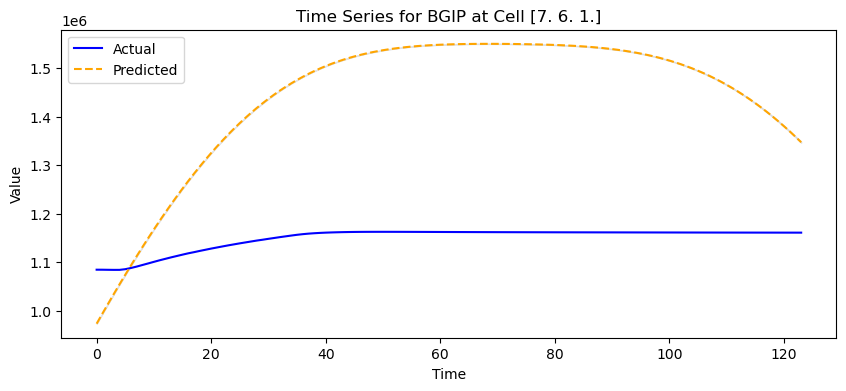

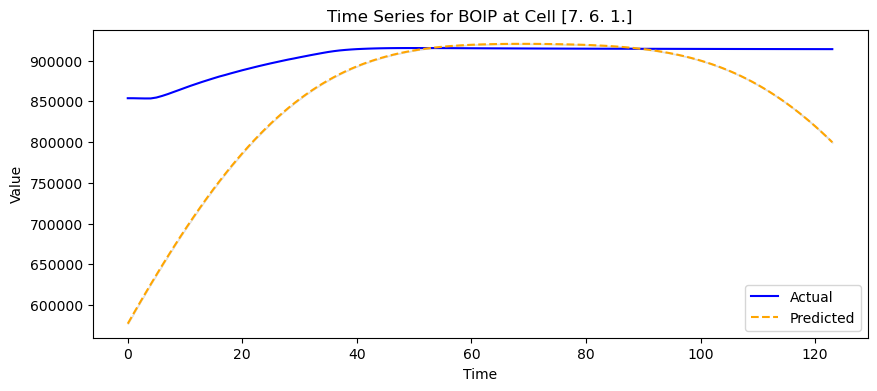

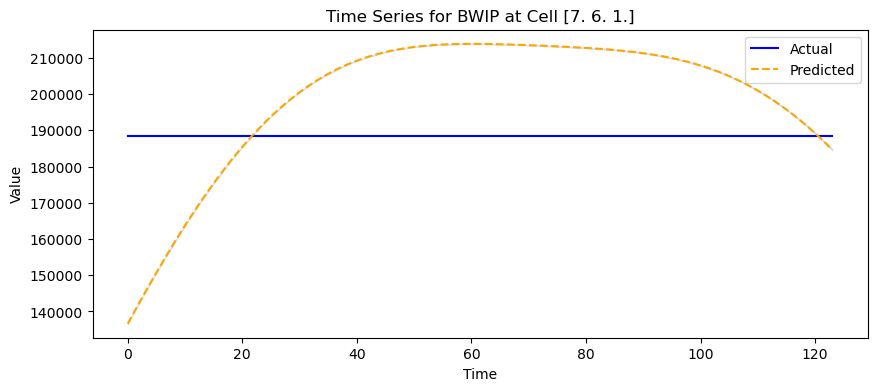

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_test_cell_time_series(test_x, test_y_actual, test_y_pred, test_y_lower, test_y_upper, categories):
    """
    Plots the actual and predicted time series data for a randomly selected cell location
    from the test data.

    Parameters:
    - test_x: The test input data (tensor).
    - test_y_actual: The actual test output data (tensor).
    - test_y_pred: The predicted mean for the test data (numpy array).
    - test_y_lower: The lower bound of the confidence interval (numpy array).
    - test_y_upper: The upper bound of the confidence interval (numpy array).
    - categories: The list of category names corresponding to the outputs.
    """
    
    # Convert test_x to numpy for processing
    test_x_np = test_x.numpy()

    # Randomly select a cell location (x, y, z)
    unique_cells = np.unique(test_x_np[:, :3], axis=0)
    random_cell = unique_cells[random.randint(0, len(unique_cells) - 1)]
    print(f"Selected cell location: {random_cell}")

    # Extract indices for the selected cell
    cell_indices = np.all(test_x_np[:, :3] == random_cell, axis=1)

    # Extract actual and predicted time series data for this cell
    cell_actual_y = test_y_actual.numpy()[cell_indices]
    cell_pred_y = test_y_pred[cell_indices]
    cell_lower_y = test_y_lower[cell_indices]
    cell_upper_y = test_y_upper[cell_indices]

    # Plotting
    for i, category in enumerate(categories):
        plt.figure(figsize=(10, 4))
        plt.plot(cell_actual_y[:, i], label='Actual', color='blue')
        plt.plot(cell_pred_y[:, i], label='Predicted', linestyle='--', color='orange')
        plt.fill_between(range(cell_pred_y.shape[0]), cell_lower_y[:, i], cell_upper_y[:, i], alpha=0.2, color='grey')
        plt.title(f'Time Series for {category} at Cell {random_cell}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

# Example usage
categories = ['BGPR', 'BGIP', 'BOIP', 'BWIP']
plot_test_cell_time_series(test_x_tensor, test_y_tensor, test_y_pred_np, test_y_lower_np, test_y_upper_np, categories)


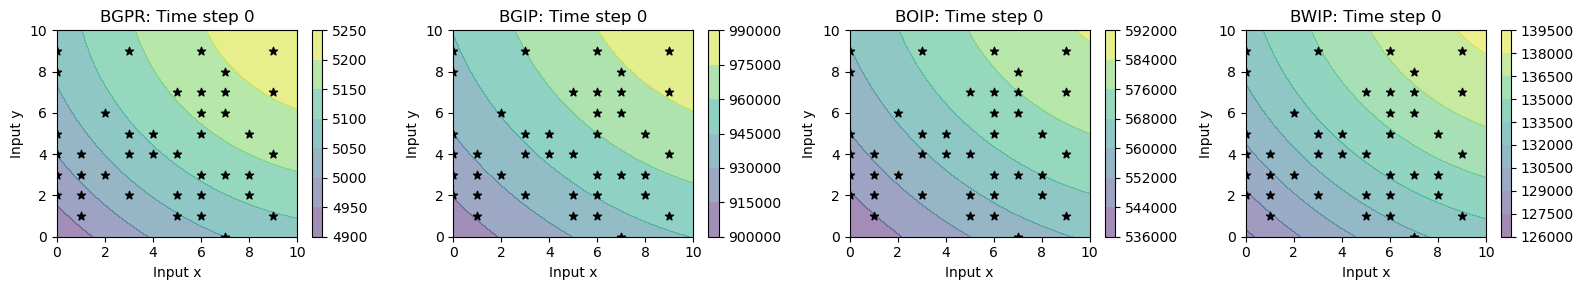

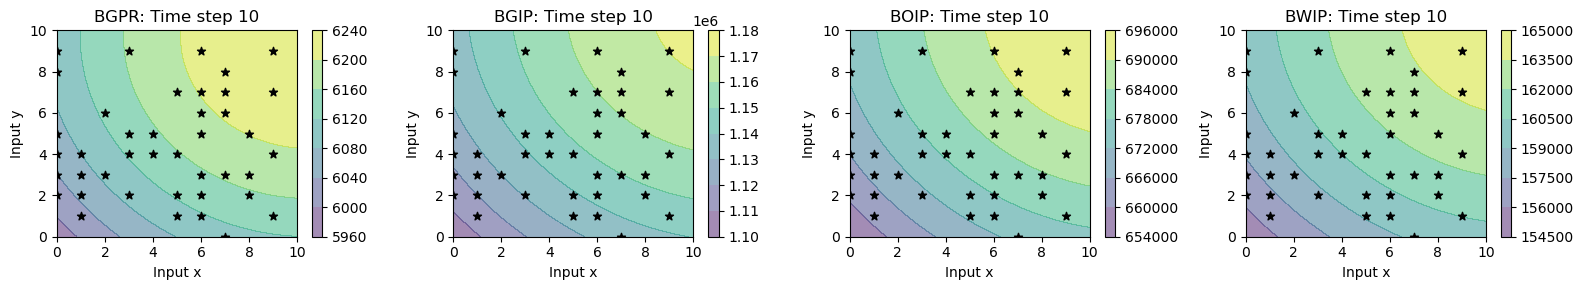

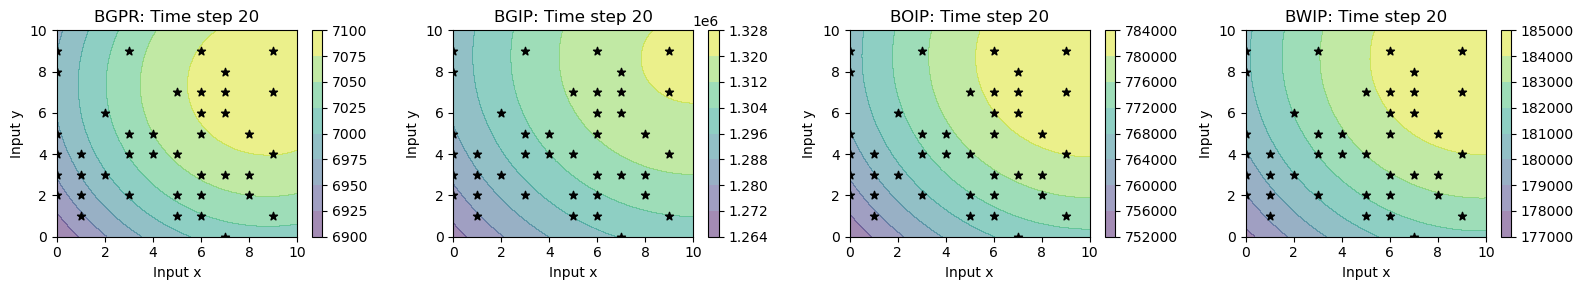

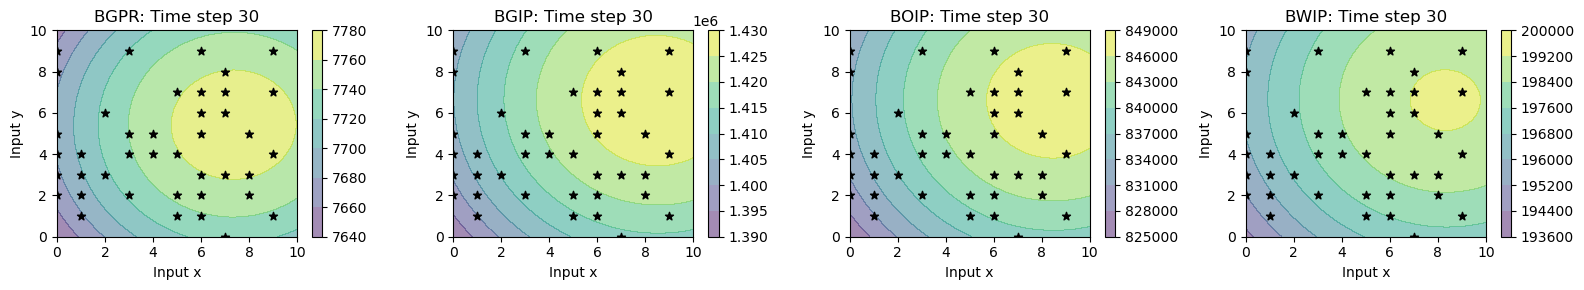

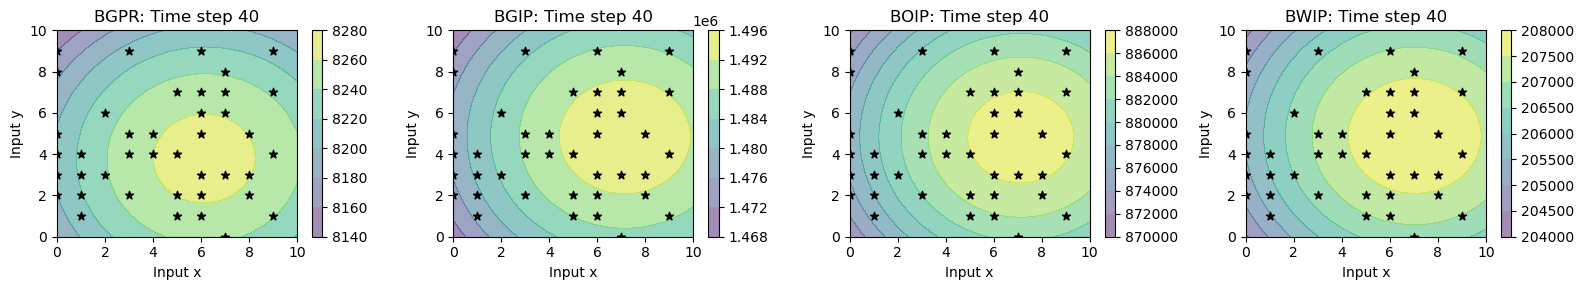

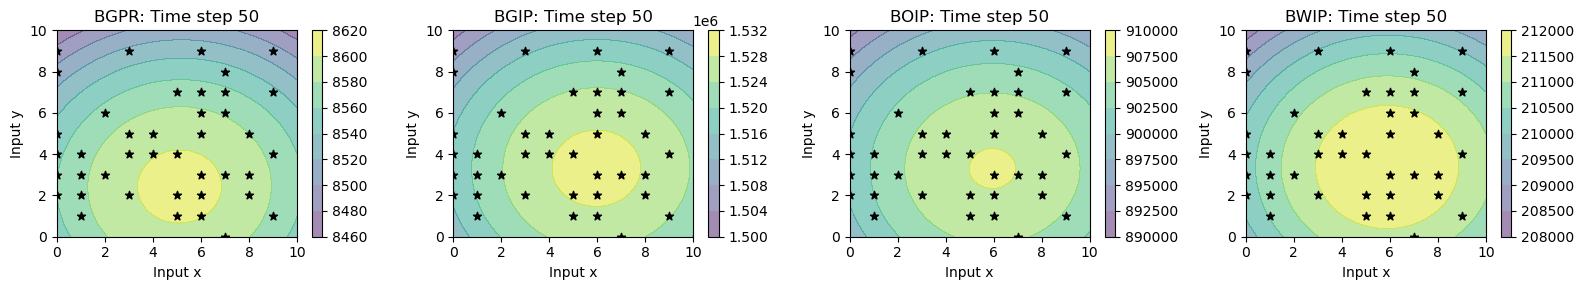

In [21]:
def plot_predictions_every_tenth_step(model, likelihood, train_x, num_tasks, task_labels, z_val=0):
    """
    Plots the predicted means and training data points on a 2D grid every 10 time steps.

    Parameters:
    - model: The trained GP model.
    - likelihood: The likelihood associated with the GP model.
    - train_x: The training input data.
    - num_tasks: The number of tasks.
    - task_labels: The labels for each task.
    - z_val: The fixed z value for which to plot predictions.
    """

    # Create a 2D grid for x and y
    test_x1 = torch.linspace(0, 10, 50)
    test_x2 = torch.linspace(0, 10, 50)
    test_x_grid, test_y_grid = torch.meshgrid(test_x1, test_x2)

    # Set model and likelihood to evaluation mode
    model.eval()
    likelihood.eval()

    # Make predictions for each tenth timestep
    for test_t in range(0, 51, 10):  # Adjust the range if needed
        test_x_2d = torch.stack([
            test_x_grid.flatten(), 
            test_y_grid.flatten(), 
            torch.full_like(test_x_grid.flatten(), z_val), 
            torch.full_like(test_y_grid.flatten(), test_t)
        ], dim=-1)

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = likelihood(model(test_x_2d))
            mean = predictions.mean
            lower, upper = predictions.confidence_region()

        # Initialize plots
        fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

        for task, ax in enumerate(axs):
            # Reshape the outputs for plotting
            mean_2d = mean[:, task].view(test_x_grid.shape)
            
            # Plotting the mean as a contour plot
            contour = ax.contourf(test_x_grid.numpy(), test_y_grid.numpy(), mean_2d.numpy(), alpha=0.5)
            fig.colorbar(contour, ax=ax)

            # Add training data points (only those matching the fixed z and current t)
            train_points = train_x[(train_x[:, 2] == z_val) & (train_x[:, 3] == test_t), :]
            ax.scatter(train_points[:, 0], train_points[:, 1], color='k', marker='*')

            ax.set_title(f'{task_labels[task]}: Time step {test_t}')
            ax.set_xlabel('Input x')
            ax.set_ylabel('Input y')

        fig.tight_layout()
        plt.show()

# Usage example:
task_labels = ['BGPR', 'BGIP', 'BOIP', 'BWIP']  # Labels for each subplot
plot_predictions_every_tenth_step(model, likelihood, train_x, num_tasks, task_labels)


In [22]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import imageio
# import os

# # Ensure the output directory exists
# output_dir = "videos"
# os.makedirs(output_dir, exist_ok=True)

# # Set model and likelihood to evaluation mode
# model.eval()
# likelihood.eval()

# # Define the range for z and t
# z_range = range(3)  # Replace with actual range if different
# t_range = range(124)  # Replace with your actual number of time steps

# # Create frames for each time step
# frames = []
# for t in t_range:
#     # Generate a test tensor for all x and y points at the current time and z layer
#     test_x_2d = torch.stack([test_x_grid.flatten(), test_y_grid.flatten(),
#                              torch.full_like(test_x_grid.flatten(), test_z),
#                              torch.full_like(test_y_grid.flatten(), t)], -1)
    
#     # Make predictions
#     with torch.no_grad(), gpytorch.settings.fast_pred_var():
#         predictions = likelihood(model(test_x_2d))
#         mean = predictions.mean

#     # Reshape the outputs for plotting
#     mean_3d = mean.view(test_x_grid.shape + (len(z_range),))

#     # Initialize the figure for the current time step
#     fig, axs = plt.subplots(1, len(z_range), figsize=(15, 5))
    
#     # Getting min and max values for consistent color mapping across layers
#     vmin_val = torch.min(mean_3d).item()
#     vmax_val = torch.max(mean_3d).item()
    
#     for z in z_range:
#         ax = axs[z]
#         # Select the slice for the current z layer
#         mean_slice = mean_3d[:, :, z]
#         im = ax.imshow(mean_slice.numpy(), cmap='viridis', vmin=vmin_val, vmax=vmax_val)
#         ax.set_title(f"Layer {z}")
        
#         # Only adding colorbar to the last subplot for cleanliness
#         if z == max(z_range):
#             fig.colorbar(im, ax=ax)
            
#     fig.suptitle(f"Predicted Mean: Time step {t}")
#     plt.tight_layout()
    
#     # Save the current frame to a temporary file
#     filename = f"{output_dir}/temp_frame_{t}.png"
#     plt.savefig(filename)
#     plt.close()
#     frames.append(imageio.imread(filename))

# # Create a video from frames
# video_filename = f'{output_dir}/predicted_mean_video.mp4'
# imageio.mimsave(video_filename, frames, fps=10, format='mp4')

# # Clean up the temporary frame images
# for frame in frames:
#     os.remove(frame)

# # Display the path to the saved video
# print(f"Video saved to {video_filename}")
